# julia itteration solver sparse src

In [1]:
import LinearAlgebra: mul!, ldiv!
import Base: getindex, iterate
using SparseArrays, Arpack, LinearAlgebra
using BenchmarkTools, IterativeSolvers, MatrixDepot, Random


struct DiagonalIndices{Tv, Ti <: Integer}
    matrix::SparseMatrixCSC{Tv,Ti}
    diag::Vector{Ti}

    function DiagonalIndices{Tv,Ti}(A::SparseMatrixCSC{Tv,Ti}) where {Tv,Ti}
        # Check square?
        diag = Vector{Ti}(undef, A.n)

        for col = 1 : A.n
            r1 = Int(A.colptr[col])
            r2 = Int(A.colptr[col + 1] - 1)
            r1 = searchsortedfirst(A.rowval, col, r1, r2, Base.Order.Forward)
            if r1 > r2 || A.rowval[r1] != col || iszero(A.nzval[r1])
                throw(LinearAlgebra.SingularException(col))
            end
            diag[col] = r1
        end 

        new(A, diag) #
    end
end

DiagonalIndices(A::SparseMatrixCSC{Tv,Ti}) where {Tv,Ti} = DiagonalIndices{Tv,Ti}(A)
@inline getindex(d::DiagonalIndices, i::Int) = d.diag[i]


struct FastLowerTriangular{Tv,Ti}
    matrix::SparseMatrixCSC{Tv,Ti}
    diag::DiagonalIndices{Tv,Ti}
end

struct FastUpperTriangular{Tv,Ti}
    matrix::SparseMatrixCSC{Tv,Ti}
    diag::DiagonalIndices{Tv,Ti}
end

struct StrictlyUpperTriangular{Tv,Ti}
    matrix::SparseMatrixCSC{Tv,Ti}
    diag::DiagonalIndices{Tv,Ti}
end

struct StrictlyLowerTriangular{Tv,Ti}
    matrix::SparseMatrixCSC{Tv,Ti}
    diag::DiagonalIndices{Tv,Ti}
end

struct OffDiagonal{Tv,Ti}
    matrix::SparseMatrixCSC{Tv,Ti}
    diag::DiagonalIndices{Tv,Ti}
end


function forward_sub!(F::FastLowerTriangular, x::AbstractVector)
    A = F.matrix
    @inbounds for col = 1 : A.n
        idx = F.diag[col]
        x[col] /= A.nzval[idx] # ok
        for i = idx + 1 : (A.colptr[col + 1] - 1) #colptr인데 lower triangular이기 때문에 해당 col의 diagonal 아래 개수가나옴.
            x[A.rowval[i]] -= A.nzval[i] * x[col] # 이 term으로 x[n] 계산할때 그이전텀들이 다 마이너스 되어서 있음. 
        end
    end
    x
end

function backward_sub!(F::FastUpperTriangular, x::AbstractVector)
    A = F.matrix

    @inbounds for col = A.n : -1 : 1

        # Solve for diagonal element
        idx = F.diag[col]
        x[col] = x[col] / A.nzval[idx]

        # Substitute next values involving x[col]
        for i = A.colptr[col] : idx - 1
            x[A.rowval[i]] -= A.nzval[i] * x[col]
        end
    end

    x
end




include group.jl for user defined matrix generators
verify download of index files...
used remote site is https://sparse.tamu.edu/?per_page=All
populating internal database...


backward_sub! (generic function with 1 method)

## Matrix Generator

In [4]:
import Distributions: MvNormal, rand
n = 3
d = MvNormal(zeros(n), ones(n))
v = rand(d)

3-element Array{Float64,1}:
  1.3920305734980842 
  0.584194396000457  
 -0.17963978305960232

In [5]:
using BenchmarkTools, IterativeSolvers, LinearAlgebra, MatrixDepot, Random


using LinearAlgebra
using SparseArrays

function cartesianidx(k::Int, n::Int)
    """
    {s_i} are on a regular 10 by 10 lattice over the two dimensional domain
    S = [1, 10] \times [1, 10].
    output gives a cartesian index (i, j) of s_k, i.e., 
    S = [s01 s11 s21 ... s91
         s02 s12 s22 ... s92
         s03 s13 s23 ... s93
            ... ... 
         s10 s20 s30 ... s100]
    """
    if k % n == 0
        [n; k ÷ n]
    else
        [k % n; k ÷ n + 1]
    end
end

"""
n_i is the number of points neighbouring s_i, i.e., with distance 1from s_i
N[i, j] = n_k, where cartesianindex(k, 10) = (i, j)
"""

function gen_Ab(n)
    #n = 10
    N = 4 * ones(n, n);
    for k in 1:n
        N[1, k] -= 1
        N[k, 1] -= 1
        N[n, k] -= 1
        N[k, n] -= 1
    end

    """
    6.1 A 10 by 10 lattice example (n = 100)
    """
    A = zeros(n^2, n^2)
    for i in 1:n^2
        for j in 1:n^2
            if i == j
                A[i, j] = 0.0001 + N[i]
            elseif norm(cartesianidx(i, n)-cartesianidx(j, n)) <= 1.0
                A[i, j] = -1.0
            else
                A[i, j] = 0.0
            end
        end
    end

    A = sparse(A)
    b = randn(n^2)
    
    (A,b)
end



function gen_Ab_temp(n)
    #n = 100
    # Poisson matrix of dimension n^2=10000, pd and sparse
    A = matrixdepot("poisson", n)
    @show typeof(A)
    # dense matrix representation of A
    #Afull = convert(Matrix, A)
    #@show typeof(Afull)
    # sparsity level
    count(!iszero, A) / length(A)
    b = randn(n^2)
    (A,b)
end

gen_Ab_temp (generic function with 1 method)

In [6]:
A, b = gen_Ab(10)

(
  [1  ,   1]  =  2.0001
  [2  ,   1]  =  -1.0
  [11 ,   1]  =  -1.0
  [1  ,   2]  =  -1.0
  [2  ,   2]  =  3.0001
  [3  ,   2]  =  -1.0
  [12 ,   2]  =  -1.0
  [2  ,   3]  =  -1.0
  [3  ,   3]  =  3.0001
  [4  ,   3]  =  -1.0
  [13 ,   3]  =  -1.0
  [3  ,   4]  =  -1.0
  ⋮
  [97 ,  97]  =  3.0001
  [98 ,  97]  =  -1.0
  [88 ,  98]  =  -1.0
  [97 ,  98]  =  -1.0
  [98 ,  98]  =  3.0001
  [99 ,  98]  =  -1.0
  [89 ,  99]  =  -1.0
  [98 ,  99]  =  -1.0
  [99 ,  99]  =  3.0001
  [100,  99]  =  -1.0
  [90 , 100]  =  -1.0
  [99 , 100]  =  -1.0
  [100, 100]  =  2.0001, [-0.9006937641021316, -1.3782616932268623, 1.5475708697976933, 0.21263365013108032, 1.2371396056849417, 1.9196695268195083, 0.3911369358039902, -1.7670121146358675, -0.41124615726840186, -0.596863100683971  …  -0.5108222190382877, 1.7534855920988361, -0.5519517486735552, -0.21567233098638455, 0.6322954432458128, 1.8606539919389156, 0.857781570741307, -1.1450212652047125, -0.134326959057419, -0.46732299622579976])

┌ Info: Recompiling stale cache file C:\Users\cobook\.julia\compiled\v1.2\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


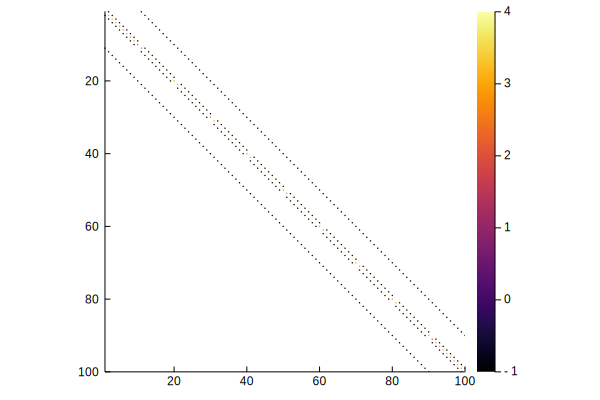

In [8]:
using Plots
spy(A)

# K3 src

# SOR

In [14]:
function f_mul!(α::T, O::DiagonalIndices, x::AbstractVector, b::AbstractVector, r::AbstractVector  ) where {T}
    A = O.matrix
    r[:] = b
    @inbounds for col = 1 : A.n
        αx = α * x[col]
        diag_index = O.diag[col]
        for j = A.colptr[col] : A.colptr[col + 1] - 1
            r[A.rowval[j]] += A.nzval[j] * αx 
        end
    end
    r
end

function sum!(z, r, A::SparseMatrixCSC)
    @inbounds for i =1: A.n
        z[i] += r[i]
    end
end


function m_sor!(A, D::DiagonalIndices, w)
    for d_idx in D.diag 
        A.nzval[d_idx]  *= (1/w)
    end
    @inbounds for col = 1 : A.n
        for j = A.colptr[col] :  A.colptr[col + 1] - 1
            if A.rowval[j] < col 
                A.nzval[j] = 0
            end
        end
    end
    
end


function itter_sor!(F::FastLowerTriangular, D::DiagonalIndices,
                        x::AbstractVector, b::AbstractVector, max_itter)
    A = D.matrix
    T = eltype(x)
    r =zeros(A.n)
    
    for i = 1 : max_itter 
        f_mul!(-one(T), D, x, b, r) # r <- b- Ax
        
        if norm(r) < 10^(-8)
            println("sor_itter : ",i)
            break
        end 
        
        forward_sub!(F, r)# r <- M_sor\r
        sum!(x, r, A) # x <- x +  M_sor/b        
    end
    x
    
end

function k3_sor(A, b::AbstractVector, w, maxiter)
    x = zeros(A.n)
    m_sor = copy(A)
    D = DiagonalIndices(A)
    m_sor!(m_sor, D, w)
    D_ms = DiagonalIndices(m_sor)
    itter_sor!(FastLowerTriangular(m_sor ,D_ms), D, x , b, maxiter)
end



k3_sor (generic function with 1 method)

# SSOR

In [20]:
function gamma_sqrt_diag_mul!( D::DiagonalIndices, b::AbstractVector, w ,b_c)
    A = D.matrix
    for idx in D.diag 
        b[A.rowval[idx]] *=  sqrt( b_c * ((2/w) -1) * A.nzval[idx])
    end
end

function sum2!(x,y,z, A::SparseMatrixCSC)
    @inbounds for i =1: A.n
        x[i] =y[i]+z[i]
    end
end

function itter_ssor!(F::FastLowerTriangular, U::FastUpperTriangular, D::DiagonalIndices,
                        D_t::DiagonalIndices, x::AbstractVector, b::AbstractVector
                        , w,  max_itter)
    
    A = D.matrix
    A_t = D_t.matrix
    #symetric일때도 필요한지 고려 diag정의는 새로필요한거 같음
    
    T = eltype(b)
    r = zeros(A.n)
    y = zeros(A.n)
        
    for i = 1 : max_itter 
        f_mul!(-one(T), D, x, b, r) # r_1 <-  γ * D^(1/2) * b- Ay
        
        if norm(r) < 10^(-8)
            println("ssor_itter : ",i)
            break
        end 
        
        gamma_sqrt_diag_mul!(D,r,w,1)
        forward_sub!(F, r) #r_1 <- m_sor\r_1
        gamma_sqrt_diag_mul!(D,r,w,1)
        backward_sub!(U, r)
        sum!(x, r, A)

    end
    x
end



function k3_ssor(A, b::AbstractVector, w, maxiter)
    x = zeros(A.n)
    m_sor = copy(A)
    D = DiagonalIndices(A)
    D_t = DiagonalIndices(sparse(A'))
    
    m_sor!(m_sor, D, w)
    
    D_ms = DiagonalIndices(m_sor)
    m_sor_t = sparse(m_sor')
    D_ms_t = DiagonalIndices(m_sor_t)
    
    itter_ssor!(FastLowerTriangular(m_sor ,D_ms), FastUpperTriangular(m_sor_t,D_ms_t),
                    D, D_t, x , b, w, maxiter)
end


k3_ssor (generic function with 1 method)

# SSOR_sampler

In [31]:
using Distributions
z =rand(Normal(0, 1), 100)

100-element Array{Float64,1}:
 -0.5124552231739169  
 -2.425639997924192   
  1.9238184916480836  
 -0.16212286880551188 
 -1.1601179585264718  
 -0.044272755702636744
  0.07489748175845938 
 -0.5359120214640507  
 -0.7654642429286692  
  1.2167230618115852  
 -0.6175770012635389  
 -0.17381071366302694 
  1.592035281317078   
  ⋮                   
  1.963549905650691   
  1.3403173379459523  
  0.9117772922210929  
  0.2564638669365862  
  0.5423378300524058  
  0.16783037312317542 
  1.8901821921483715  
 -1.9742772986224124  
 -0.3111955134445697  
 -0.8202654356175954  
 -1.2574508973031735  
 -2.1898730614952355  

In [51]:

mutable struct Sample_arr
    y::Matrix{Float64}
end

# r<-α(M-A)x +b
function f_mul_2!(α::T, O::DiagonalIndices, F::FastLowerTriangular, x::AbstractVector, b, r::AbstractVector  ) where {T} 
    A = O.matrix
    M = F.matrix
    r[:] = b
    @inbounds for col = 1 : A.n
        αx = α * x[col]
        diag_index = O.diag[col]
        for j = A.colptr[col] : A.colptr[col + 1] - 1
            r[A.rowval[j]] += (M.nzval[j] - A.nzval[j]) * αx 
        end
    end
    r
end

function f_mul_2!(α::T, O::DiagonalIndices, U::FastUpperTriangular, x::AbstractVector, b, r::AbstractVector  ) where {T} 
    A = O.matrix
    M = U.matrix
    r[:] = b
    @inbounds for col = 1 : A.n
        αx = α * x[col]
        diag_index = O.diag[col]
        for j = A.colptr[col] : A.colptr[col + 1] - 1
            r[A.rowval[j]] += (M.nzval[j] - A.nzval[j]) * αx 
        end
    end
    r
end



function itter_ssor_sp!(F::FastLowerTriangular, U::FastUpperTriangular, D::DiagonalIndices,
                        D_t::DiagonalIndices, x::AbstractVector, w,  max_itter)
    
    A = D.matrix
    A_t = D_t.matrix   
    T = eltype(x)
    r = zeros(A.n)
    y = zeros(A.n)
        
    for i = 1 : max_itter 
        
        z =rand(Normal(0, 1), A.n)
        gamma_sqrt_diag_mul!(D,z,w,1)   # z[A.rowval[idx]] *=  sqrt( b_c * ((2/w) -1) * A.nzval[idx])
        f_mul_2!(1, D, F, x, z, y) #y <- α(M-A)x +b
        forward_sub!(F, y) #r_1 <- m_sor\r_1
        z =rand(Normal(0, 1), 100)
        
        gamma_sqrt_diag_mul!(D,z,w,1)
        f_mul_2!(1, D_t, U, y, z, x) # r<-α(M-A)x +b 맨마지막 ㅔㅂㄱ터네 넣음
        backward_sub!(U, x)
        
        #print(x)

    end
    x
end



function k3_ssor_sp(A, w, maxiter)
    x = zeros(A.n)
    m_sor = copy(A)
    D = DiagonalIndices(A)
    D_t = DiagonalIndices(sparse(A'))
    
    m_sor!(m_sor, D, w)
    
    D_ms = DiagonalIndices(m_sor)
    m_sor_t = sparse(m_sor')
    D_ms_t = DiagonalIndices(m_sor_t)
    
    itter_ssor_sp!(FastLowerTriangular(m_sor ,D_ms), FastUpperTriangular(m_sor_t,D_ms_t),
                    D, D_t, x , w, maxiter)
end

k3_ssor_sp (generic function with 1 method)

In [45]:
A, _ = gen_Ab(10)

(
  [1  ,   1]  =  2.0001
  [2  ,   1]  =  -1.0
  [11 ,   1]  =  -1.0
  [1  ,   2]  =  -1.0
  [2  ,   2]  =  3.0001
  [3  ,   2]  =  -1.0
  [12 ,   2]  =  -1.0
  [2  ,   3]  =  -1.0
  [3  ,   3]  =  3.0001
  [4  ,   3]  =  -1.0
  [13 ,   3]  =  -1.0
  [3  ,   4]  =  -1.0
  ⋮
  [97 ,  97]  =  3.0001
  [98 ,  97]  =  -1.0
  [88 ,  98]  =  -1.0
  [97 ,  98]  =  -1.0
  [98 ,  98]  =  3.0001
  [99 ,  98]  =  -1.0
  [89 ,  99]  =  -1.0
  [98 ,  99]  =  -1.0
  [99 ,  99]  =  3.0001
  [100,  99]  =  -1.0
  [90 , 100]  =  -1.0
  [99 , 100]  =  -1.0
  [100, 100]  =  2.0001, [2.2638540372667224, 1.3907510295142373, -1.0182976967861492, 0.050965676448711694, -0.0006924952427944482, 0.7249255301198793, -1.7141778725451116, 0.16612323579676205, -0.8086959290771711, -1.2942179543928778  …  0.07961406449318954, 0.6322684585859003, 1.6245459519806922, -0.1187894144006013, 0.24647581939854699, 1.3396081944526985, -0.6411872895960686, -0.08404785216843856, -0.6526596623802904, -0.6950702294529684])

In [49]:
 k3_ssor_sp(A, 0.5, 10)

[0.6055752021835803, 0.209084168837597, -0.5474900166989612, -0.2078997383224818, 1.2524524193485718, 0.7190071120411715, -0.36798572942566354, 0.3646111795629283, 0.4238225406497919, 0.9241077455152609, -0.8808776057125649, -0.034183054907691905, 0.0846919347407742, -0.5418119808912677, 0.28873572259510205, 0.2762426788833869, 0.2233712078359869, 0.7275971162217336, 1.2231223510222267, 0.6283229594482094, 0.45262257402571443, 0.1462677178681808, -0.7344889509812983, -0.2460691267493849, -0.21727758442796857, 0.4138806486713185, -0.727628077341425, -0.3142773883417998, -0.4186667093979744, -0.08030966575655611, 0.38207841561516165, 0.5543592560353272, 0.7472643686621523, -0.9156984816918413, 0.3496104589782496, 1.4379180498502877, -0.5438389726811675, -0.48915779731908166, 0.48330374810062815, -0.2547416734922029, 1.323320270237055, 0.5593695970799505, 0.719176295922351, 0.6283155952765229, -0.2319470721975457, 0.5378783204076726, -0.13855999276745126, -0.4014652857441935, -0.293238689

100-element Array{Float64,1}:
  2.1253954525101677 
  1.8205460466704513 
  1.8712267335075752 
  1.4721729987779626 
  1.479275744218362  
  2.8483013689704317 
  0.9120060763720049 
  0.43667565179519346
 -0.22479928685793701
  1.4691862908266042 
  1.449904231222142  
  1.3589463195559763 
  0.7968793767247621 
  ⋮                  
  1.542679229508103  
  1.2285399273230033 
 -1.7300894679469785 
 -1.7486794676703115 
 -0.9124369984402361 
 -0.8215950745823495 
 -1.3110689298534466 
 -1.9847471243513464 
 -1.1731077356942639 
  0.5643792400660775 
  1.2974281841082294 
  0.4859402834450711 

# Cheby_SSOR

In [88]:
import Distributions: MvNormal, rand

mutable struct CB_variable
    β::Float64
    α::Float64
    b::Float64
    a::Float64
    κ::Float64
end

function mul_sum!(x_next, x, x_pre, r, α, τ, A)
    for i = 1:A.n 
        x_next[i] = (1-α)*x_pre[i] + α*x[i] + (τ*α*r[i])
    end
    # x
end



function sum2!(x_next, x, r, A)
    for i = 1:A.n 
        x_next[i] = x[i] + r[i]
    end
    # x
end

function sum3!(w_v, x_temp , x, r, A)
    for i = 1:A.n 
        w_v[i] = x_temp[i] - x[i] + r[i]
    end
    # x
end

function eigMm(A::SparseMatrixCSC, ω::Real)

    Dw = sqrt((2/ω-1)) * Diagonal(sqrt.(diag(A)))
    L = (LowerTriangular(A)- (1-1/ω) * Diagonal(A))*(inv(Dw))

    Meig = inv(cholesky(L*L')) * A
    
    λ_max = eigs(Meig; nev=1, ritzvec=false, which=:LM)[1][1]
    λ_min = eigs(Meig; nev=1, ritzvec=false, which=:SM)[1][1]
    real(λ_max), real(λ_min)
end


function itter_CB_ssor!(F::FastLowerTriangular, U::FastUpperTriangular, D::DiagonalIndices,
                        D_t::DiagonalIndices, x::AbstractVector, b::AbstractVector
                        , w,  λ_max, λ_min, max_itter)
    
    
    
    A = D.matrix
    A_t = D_t.matrix
    
    δ = ((λ_max - λ_min)/4)^2
    τ = 2/(λ_max + λ_min)
    
    T = eltype(b)
    cb = CB_variable(0,0,0,0,0)
    #Assign initial parameter
    cb.β  = 2*τ
    cb.α = 1
    cb.b = 2/cb.α - 1
    cb.a = (2/τ -1) * cb.b
    cb.κ = τ
    
    T = eltype(b)
    r_1 = zeros(A.n)
    r_2 = zeros(A.n)
    x_pre = zeros(A.n)
    x_next = zeros(A.n)
    x_temp = zeros(A.n)
    w_v = zeros(A.n)
 
    for i = 1 : max_itter 

        x_pre[:] = x 
        x[:] = x_next
        
        f_mul!(-one(T), D, x, b, r_1) # r <- b - A* X        

        forward_sub!(F, r_1) #r_1 <- m_sor\r_1
        sum2!(x_temp, x, r_1, A) #x_next <- x + τ*r
        
        f_mul!(-one(T), D, x_temp, b, r_2) # r_2 <- b - A* X
        backward_sub!(U, r_2)
        sum3!(w_v, x_temp , x, r_2, A)
        
        if i == 1
            sum2!(x_next, cb.α*x, τ*w_v, A) #x_next <- x + τ*r
        else
            mul_sum!(x_next, x, x_pre, w_v, cb.α, τ, A) # x_next <- (1-α)*x_pre + α*x + (τ*α*r[i])

        end
        
        
        cb.β = 1 / ( (1/τ)  - cb.β*δ ) 
        cb.α = cb.β / τ
        cb.b = ( ( 2*cb.κ*(1- cb.α) ) / cb.β) + 1
        cb.a = ((2/τ) -1) + (cb.b-1) * ( (1/τ) + (1/cb.κ) -1 )
        cb.κ = cb.β  + ( (1 - cb.α) * cb.κ)
        
    end
    x

end



function k3_CB_ssor(A, b::AbstractVector, w, λ_max, λ_min,  maxiter)
    x = zeros(A.n)
    m_sor = copy(A)
    D = DiagonalIndices(A)
    D_t = DiagonalIndices(sparse(A'))
    
    m_sor!(m_sor, D, w)
    
    D_ms = DiagonalIndices(m_sor)
    m_sor_t = sparse(m_sor')
    D_ms_t = DiagonalIndices(m_sor_t)
    #λ_max,λ_min = eigMm(A, w)
    
    itter_CB_ssor!(FastLowerTriangular(m_sor ,D_ms), FastUpperTriangular(m_sor_t,D_ms_t),
                    D, D_t, x , b, w, λ_max, λ_min, maxiter)
end


k3_CB_ssor (generic function with 2 methods)

# Cheby_SSOR sampler

In [18]:
function gamma_sqrt_diag_mul!( D::DiagonalIndices, b::AbstractVector, w ,b_c)
    A = D.matrix
    for idx in D.diag 
        b[A.rowval[idx]] *=  sqrt( b_c * ((2/w) -1) * A.nzval[idx])
    end
end



function eigMm(A::SparseMatrixCSC, ω::Real)

    Dw = sqrt((2/ω-1)) * Diagonal(sqrt.(diag(A)))
    L = (LowerTriangular(A)- (1-1/ω) * Diagonal(A))*(inv(Dw))

    Meig = inv(cholesky(L*L')) * A
    
    λ_max = eigs(Meig; nev=1, ritzvec=false, which=:LM)[1][1]
    λ_min = eigs(Meig; nev=1, ritzvec=false, which=:SM)[1][1]
    real(λ_max), real(λ_min)
end



mutable struct CB_variable
    β::Float64
    α::Float64
    b::Float64
    a::Float64
    κ::Float64
end

function mul_sum!(x_next, x, x_pre, r, α, τ, A)
    for i = 1:A.n 
        x_next[i] = (1-α)*x_pre[i] + α*x[i] + (τ*α*r[i])
    end
    # x
end



function sum2!(x_next, x, r, A)
    for i = 1:A.n 
        x_next[i] = x[i] + r[i]
    end
    # x
end

function sum3!(w_v, x_temp , x, r, A)
    for i = 1:A.n 
        w_v[i] = x_temp[i] - x[i] + r[i]
    end
    # x
end

function eigMm(A::SparseMatrixCSC, ω::Real)

    Dw = sqrt((2/ω-1)) * Diagonal(sqrt.(diag(A)))
    L = (LowerTriangular(A)- (1-1/ω) * Diagonal(A))*(inv(Dw))

    Meig = inv(cholesky(L*L')) * A
    
    λ_max = eigs(Meig; nev=1, ritzvec=false, which=:LM)[1][1]
    λ_min = eigs(Meig; nev=1, ritzvec=false, which=:SM)[1][1]
    real(λ_max), real(λ_min)
end


function itter_CB_ssor_sp!(F::FastLowerTriangular, U::FastUpperTriangular, D::DiagonalIndices,
                        D_t::DiagonalIndices, x::AbstractVector, ν, w,  λ_max, λ_min, max_itter)
    
    A = D.matrix
    A_t = D_t.matrix
    
    δ = ((λ_max - λ_min)/4)^2
    τ = 2/(λ_max + λ_min)
    print("hi")

    T = eltype(x)
    cb = CB_variable(0,0,0,0,0)
    #Assign initial parameter
    cb.β  = 2*τ
    cb.α = 1
    cb.b = 2/cb.α - 1
    cb.a = (2/τ -1) * cb.b
    cb.κ = τ
    
    T = eltype(x)
    r_1 = zeros(A.n)
    r_2 = zeros(A.n)
    x_pre = zeros(A.n)
    x_next = zeros(A.n)
    x_temp = zeros(A.n)
    w_v = zeros(A.n)

    d = MvNormal( ν , ones( A.n))
    
    for i = 1 : max_itter 

        x_pre[:] = x 
        x[:] = x_next
        
        z = rand(d) 
        gamma_sqrt_diag_mul!( D, z, w , cb.b) #z <- z *  b^1/2 D_w^1/2 

        f_mul!(-one(T), D, x, z, r_1) # r <- z - A* X                
        forward_sub!(F, r_1) #r_1 <- m_sor\r_1
        sum2!(x_temp, x, r_1, A) #x_next <- x + τ*r
        
        z = rand(d) 
        gamma_sqrt_diag_mul!( D, z, w , cb.a) #z <- z *  b^1/2 D_w^1/2         
        
        f_mul!(-one(T), D, x_temp, z, r_2) # r_2 <- z - A* X
        backward_sub!(U, r_2)
        sum3!(w_v, x_temp , x, r_2, A)
        
        if i == 1
            sum2!(x_next, cb.α*x, τ*w_v, A) #x_next <- x + τ*r
        else
            mul_sum!(x_next, x, x_pre, w_v, cb.α, τ, A) # x_next <- (1-α)*x_pre + α*x + (τ*α*r[i])

        end
        
        
        cb.β = 1 / ( (1/τ)  - cb.β*δ ) 
        cb.α = cb.β / τ
        cb.b = ( ( 2*cb.κ*(1- cb.α) ) / cb.β) + 1
        cb.a = ((2/τ) -1) + (cb.b-1) * ( (1/τ) + (1/cb.κ) -1 )
        cb.κ = cb.β  + ( (1 - cb.α) * cb.κ)
        
        fvars["x_(itter)"].μ <- += μ
        
    end
    x

end


function k3_CB_ssor_sp(A, ν, w, λ_max, λ_min,  maxiter)
    x = zeros(A.n)
    m_sor = copy(A)
    D = DiagonalIndices(A)
    D_t = DiagonalIndices(sparse(A'))
    m_sor!(m_sor, D, w)

    D_ms = DiagonalIndices(m_sor)
    m_sor_t = sparse(m_sor')
    D_ms_t = DiagonalIndices(m_sor_t)

    itter_CB_ssor_sp!(FastLowerTriangular(m_sor ,D_ms), FastUpperTriangular(m_sor_t,D_ms_t),
                    D, D_t, x , ν, w, λ_max, λ_min, maxiter)
end


k3_CB_ssor_sp (generic function with 1 method)

In [2]:
#variance_container is needed

mutable struct Sampling_container
    xtx::Float64
    μ::Float64
    sample_n::Float64
end
 

In [6]:
fvars = Dict()
#initial declare
for n= 1: 10
    fvars["x_$(n)"] = Sampling_container(n,n,n)

end


In [7]:
fvars["x_9"].μ

9.0

In [ ]:
import Distributions: MvNormal, rand
n = 3
d = MvNormal(zeros(n), ones(n))
v = rand(d)

In [19]:
using Distributions
w = 1.6641
ν = rand(Normal(0, 1.0), 100)
λ_max,λ_min = eigMm(A, w)
k3_CB_ssor_sp(A, ν, w, λ_max, λ_min,  10)

100-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

100-element Array{Float64,1}:
 -0.42545419380739746  
  0.2664194929746199   
  0.07048017177342177  
  0.4035001828761146   
  1.3595534771250208   
  0.9013266409594851   
  1.614514634398622    
  0.8602756213777832   
  0.4418814661716473   
  1.4147152273940673   
 -0.8715068019724838   
 -1.4950344912228237   
  1.1316845996813545   
  ⋮                    
 -0.14344564747394778  
 -1.1336090427268997   
  0.05991992306730307  
  0.6145292645089454   
 -0.7214800836786072   
 -0.0050133231948695945
 -1.3823319503734426   
 -0.332068584695237    
 -1.2673349402303438   
 -2.54059902469524     
 -0.6128900563676984   
 -1.294198190495952    

100-element Array{Float64,1}:
  0.4782530241988403 
 -0.3608877182242639 
 -0.9615204726840838 
  0.37715520240623274
  1.2431883084547286 
  0.783817063214542  
  0.6343070147241239 
  0.438036289571998  
  0.9945540944098594 
  1.7316433584981465 
  0.45627232817798835
 -0.25045966679433684
  0.3816362584460473 
  ⋮                  
 -1.82310123015656   
 -1.585484185476379  
  1.67680683602655   
  0.9094999192019807 
  0.1480620260777188 
  0.5386440751488571 
 -0.6478814085357301 
 -0.40931868878291744
 -1.2161097689690967 
 -2.114140175889884  
 -1.59422423408419   
 -2.0027454973348813 

100-element Array{Float64,1}:
  0.2512913877964089 
  0.10672248427163189
  0.5580827847381555 
  1.1261715486707682 
  0.9255613412559092 
  1.5940476201936808 
  1.0476077883952088 
  1.6522153193053113 
  1.9939689003017866 
  1.4440282013250363 
  0.35304481838869783
  0.708763161055354  
 -0.5155379704037159 
  ⋮                  
 -1.0556231639355484 
 -0.5872058747890245 
  0.4607006278873236 
 -0.04331971136355395
  0.905212273824242  
  0.3595198853625987 
  0.8299512278375615 
 -0.2900653526328135 
  0.12008006666782789
  0.8905240536706756 
 -0.8695269326217319 
 -0.9601885831742616 

100-element Array{Float64,1}:
  1.0577120724895153 
  1.4878888784904736 
  1.9567114643808656 
 -0.28763113470838064
 -1.7423674711639574 
 -1.044675080061268  
 -1.0876847549310624 
 -0.48979512431396843
 -0.16480353644823031
 -0.0518249742525041 
  0.5892794966532949 
  1.763822542560674  
  1.0630812879424005 
  ⋮                  
  1.6342176857155408 
  1.258760376594207  
 -0.6776305787089527 
  0.16679601131869914
  0.9773871155703788 
  0.20479296012960452
  1.5492775397451863 
  0.480858388285119  
  1.1263547398267173 
  2.074226848410886  
  0.8656099023215007 
  0.9254418344757775 

100-element Array{Float64,1}:
 0.8150280264863077
 0.9821016137861833
 1.5089370625072718
 1.0749752854107455
 1.512993465605426 
 1.6268589858264502
 2.5020962207467368
 1.668138320495017 
 1.1387260833395412
 0.7513273642549068
 1.273594510863684 
 1.2164834845936818
 1.2048235759838979
 ⋮                 
 2.2376797267280018
 2.0765290084304118
 0.3284250405608726
 1.3064399373592868
 0.6839825243777402
 0.8614156066596889
 0.9249444198344905
 1.6118937363850927
 1.5231537281940615
 0.9575192746087136
 1.9931856040645863
 2.1351818651221555

100-element Array{Float64,1}:
  1.396896205067792   
  0.8575469372376594  
  0.026209612824012574
  1.3315227901162303  
  1.4117434886275628  
 -0.3278443556379509  
 -0.10308305309571342 
 -0.8599770501814898  
 -0.792599173936849   
 -0.7596285247005947  
  1.9712511309777712  
  0.9462157269920979  
  1.4161551110279411  
  ⋮                   
  1.5286717083076968  
  1.800885025305141   
  1.5590391386941718  
  1.2792223088594314  
  0.4422154044416221  
  1.5914936106101247  
 -0.012544251604500456
  1.493180299576758   
  1.2741758151628195  
  0.855168147736721   
  2.5802525404506196  
  2.3066242887216606  

100-element Array{Float64,1}:
  0.45858981277922695
  1.5705527154189025 
  1.0522484588071004 
  2.228512691718121  
  2.371011208199122  
  2.0053662008145223 
  0.8079061359202471 
  0.6901947715389536 
  0.424491050912271  
  0.5625153815397388 
 -0.02314036305099343
  0.1850622242151042 
  0.9221883589846742 
  ⋮                  
  0.6090985632585588 
  1.1244515966777844 
  1.3821809466608705 
  0.4346478136094213 
  0.5361968855173294 
  1.7540036406560269 
  1.266584622881365  
  1.0375189924795771 
  0.7443147004505533 
  1.124259254193413  
  1.4229321905470431 
  1.178362426420893  

100-element Array{Float64,1}:
  1.3689052793139291  
  0.34660277495171976 
  0.3863653725808962  
 -0.6760813325167279  
 -0.3583637166401936  
  1.0258917623905313  
  0.2474058419164873  
  0.9879780214043163  
  1.4370275588525228  
  2.38441459253175    
  1.210935244567287   
  1.1814767640200543  
  1.054530391556154   
  ⋮                   
  0.4913761306584917  
  0.5829195139576613  
  1.584523145485143   
  1.158371110724274   
  1.5465196824249516  
  0.6381180818561332  
  2.151327154737532   
  0.8747178995151804  
  0.4427856108098027  
  1.186067112958183   
 -0.038484217881770866
  0.06334706004100332 

100-element Array{Float64,1}:
  0.5939581518367003 
  0.5937006683693969 
  2.693260433633842  
  1.994958790464108  
  1.6013635997373679 
  1.7737848646383498 
  2.548895212678733  
  2.583706066689916  
  2.7842921876210958 
  2.723642939090439  
  0.299507756322134  
  1.1031299972053534 
  1.0404580872395295 
  ⋮                  
  0.9465912471336523 
  0.14025167269887984
  1.5854745509930446 
  2.450847422853052  
  2.74863516971108   
  0.6404720601679501 
  1.0993218191681973 
  0.5932469018868759 
  0.732354173511234  
  0.813869139858834  
 -0.13177646161587453
 -0.3956384884844354 

hi

100-element Array{Float64,1}:
  0.5939581518367003 
  0.5937006683693969 
  2.693260433633842  
  1.994958790464108  
  1.6013635997373679 
  1.7737848646383498 
  2.548895212678733  
  2.583706066689916  
  2.7842921876210958 
  2.723642939090439  
  0.299507756322134  
  1.1031299972053534 
  1.0404580872395295 
  ⋮                  
  0.9465912471336523 
  0.14025167269887984
  1.5854745509930446 
  2.450847422853052  
  2.74863516971108   
  0.6404720601679501 
  1.0993218191681973 
  0.5932469018868759 
  0.732354173511234  
  0.813869139858834  
 -0.13177646161587453
 -0.3956384884844354 

In [86]:
import Distributions: MvNormal, rand
d = MvNormal(ν , ones( A.n))
z = rand(d) 

UndefVarError: UndefVarError: n not defined

In [87]:
ν = rand(Normal(0, 1), 100)
d = MvNormal(ν , ones(100))
z = rand(d) 

100-element Array{Float64,1}:
 -2.1953236519394057 
 -0.8948209114460233 
  1.0278859628086021 
 -0.9443145784834637 
  0.22581376583952956
 -0.7373056657947159 
 -0.7331114003557716 
  0.15450131041817594
  0.11870667396512263
  0.5848301222879921 
  0.9563485050419817 
  0.3624064889846771 
 -0.19249956108115124
  ⋮                  
 -1.5356970326890513 
 -2.5291966286241103 
 -1.1609047780046229 
 -0.14231061600328665
 -0.32767542309799785
  0.6665483359475846 
  1.9393188053823889 
  1.3708603566941016 
  1.3515963619152034 
 -1.137581955797847  
  2.5607101343787773 
 -1.0664959294988905 